In [3]:
import sys
sys.path.append("../")

from all_models import *

In [1]:
import os
import string
import numpy as np
import seaborn
import matplotlib.pyplot as plt

import torch.optim as optim

In [2]:
class Task(object):

    def __init__(self, max_len=10, vocab_size=3):
        super(Task, self).__init__()
        self.max_len = max_len
        self.vocab_size = vocab_size
        assert self.vocab_size <= 26, "vocab_size needs to be <= 26 since we are using letters to prettify LOL"

    def next_batch(self, batchsize=100):
        # This uses the matrix of random integers as indices to select rows 
        # from the identity matrix. The result is a 3D tensor of one-hot encoded sequences
        x = np.eye(self.vocab_size + 1)[np.random.choice(np.arange(self.vocab_size + 1), [batchsize, self.max_len])]
        y = np.eye(self.max_len + 1)[np.sum(x, axis=1)[:, 1:].astype(np.int32)]
        return x, y

    def prettify(self, samples):
        samples = samples.reshape(-1, self.max_len, self.vocab_size + 1)
        idx = np.expand_dims(np.argmax(samples, axis=2), axis=2)
        dictionary = np.array(list(' ' + string.ascii_uppercase))
        return dictionary[idx]

In [4]:
def train(max_len=10,
          vocab_size=3,
          hidden=64,
          batchsize=100,
          steps=2000,
          print_every=50,
          savepath='models/'):

    os.makedirs(savepath, exist_ok=True)
    model = AttentionModel(max_len=max_len, vocab_size=vocab_size, hidden=hidden)
    optimizer = optim.Adam(model.parameters(), lr=1e-2)
    lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, patience=250, verbose=True)
    task = Task(max_len=max_len, vocab_size=vocab_size)

    loss_hist = []
    for i in range(steps):
        minibatch_x, minibatch_y = task.next_batch(batchsize=batchsize)
        optimizer.zero_grad()
        with torch.set_grad_enabled(True):
            minibatch_x = torch.Tensor(minibatch_x)
            minibatch_y = torch.Tensor(minibatch_y)
            out, _ = model(minibatch_x)
            loss = F.cross_entropy(
                out.transpose(1, 2),
                minibatch_y.argmax(dim=2))
            loss.backward()
            optimizer.step()
            lr_scheduler.step(loss)
        if (i + 1) % print_every == 0:
            print("Iteration {} - Loss {}".format(i + 1, loss))
        loss_hist.append(loss.detach().numpy())

    print("Iteration {} - Loss {}".format(i + 1, loss))
    print("Training complete!")
    torch.save(model.state_dict(), savepath + '/ckpt.pt')
    return np.array(loss_hist)


def test(max_len=10,
         vocab_size=3,
         hidden=64,
         savepath='models/',
         plot=True):

    model = AttentionModel(max_len=max_len, vocab_size=vocab_size, hidden=hidden)
    model.load_state_dict(torch.load(savepath + '/ckpt.pt'))
    task = Task(max_len=max_len, vocab_size=vocab_size)

    samples, labels = task.next_batch(batchsize=1)
    print("\nInput: \n{}".format(task.prettify(samples)))
    model.eval()
    with torch.set_grad_enabled(False):
        predictions, attention = model(torch.Tensor(samples))
    predictions = predictions.detach().numpy()
    predictions = predictions.argmax(axis=2)
    attention = attention.detach().numpy()

    print("\nPrediction: \n{}".format(predictions))
    print("\nEncoder-Decoder Attention: ")
    for i, output_step in enumerate(attention[0]):
        print("Output step {} attended mainly to Input steps: {}".format(
            i, np.where(output_step >= np.max(output_step))[0]))
        print([float("{:.3f}".format(step)) for step in output_step])

    if plot:
        fig, ax = plt.subplots()
        seaborn.heatmap(
            attention[0],
            yticklabels=["output_0", "output_1", "output_2"],
            xticklabels=task.prettify(samples).reshape(-1),
            ax=ax,
            cmap='plasma',
            cbar=True,
            cbar_kws={"orientation": "horizontal"}
        )
        ax.set_aspect('equal')
        for tick in ax.get_yticklabels():
            tick.set_rotation(0)
        plt.show()
    return samples, labels, predictions, attention

In [5]:
task = Task()
samples, labels = task.next_batch()

In [6]:
# (batchsize, max_len, vocab_size + 1)
samples.shape

(100, 10, 4)

In [7]:
# 0 is ''
samples[0]

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.]])

In [8]:
# (batchsize, vocab_size, max_len + 1)
labels.shape

(100, 3, 11)

In [9]:
# A - 3
labels[0]

array([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]])

----

In [10]:
loss_hist = train(print_every=250)

Iteration 250 - Loss 0.44433340430259705
Iteration 500 - Loss 0.3043327331542969
Iteration 750 - Loss 0.1710231900215149
Iteration 1000 - Loss 0.18242114782333374
Iteration 1250 - Loss 0.12991656363010406
Iteration 1500 - Loss 0.14354442059993744
Iteration 1750 - Loss 0.08493632823228836
Iteration 2000 - Loss 0.09386644512414932
Iteration 2000 - Loss 0.09386644512414932
Training complete!


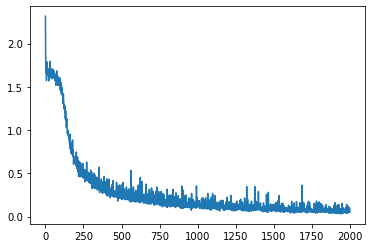

In [11]:
plt.plot(loss_hist);

----


Input: 
[[['C']
  ['B']
  ['A']
  ['B']
  ['A']
  ['A']
  ['B']
  ['B']
  ['C']
  ['B']]]

Prediction: 
[[3 5 2]]

Encoder-Decoder Attention: 
Output step 0 attended mainly to Input steps: [2 4 5]
[0.058, 0.055, 0.203, 0.055, 0.203, 0.203, 0.055, 0.055, 0.058, 0.055]
Output step 1 attended mainly to Input steps: [1 3 6 7 9]
[0.044, 0.157, 0.042, 0.157, 0.042, 0.042, 0.157, 0.157, 0.044, 0.157]
Output step 2 attended mainly to Input steps: [0 8]
[0.247, 0.063, 0.064, 0.063, 0.064, 0.064, 0.063, 0.063, 0.247, 0.063]


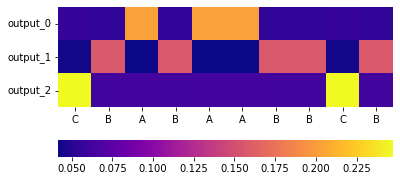

In [12]:
samples, labels, predictions, attention = test()